<a href="https://colab.research.google.com/github/CpSquared/Improving-Virtual-Colliders/blob/master/CA_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [141]:
# Sample Notebook - WGAN - Wasserstein GAN AKA Critic GAN Implementation with the help of following article
# https://machinelearningmastery.com/how-to-code-a-wasserstein-generative-adversarial-network-wgan-from-scratch/

In [64]:
%tensorflow_version 2.x
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy.stats import chisquare
from keras import backend
from keras.constraints import Constraint
from keras.optimizers import RMSprop
from numpy import mean


In [3]:
# How To Load Data with Public Shareable Link on to Google Colab : Source : https://medium.com/@acpanjan/download-google-drive-files-using-wget-3c2c025a8b99

# We First download the Data into the external Hardware Google Colab operates on, by accessing it's terminal using "!"
# To Download this data , which is uploaded in Google Drive ( Doesnt matter whose Google account), IMPORTANT : Link sharing should be public for the required file
# i.e. Anyone on internet can view the file should be turned on, once it is done, get the shareable link of the file 

# Read the Source link at the start for Details, for our case, data files are less than 100 MB, so we can download them by typing in terminal following command
# wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=FILEID' -O FILENAME

# I have saved the FileID of files we will be using below, it is the portion between d/ AND /view in the public Shareable link of file
# FILENAME can be custom according to our choice and is temporary
# NOTE : TO ACCESSS TERMINAL OF EXTERNAL HARDWARE USE " ! " BEFORE ANY COMMAND

# https://drive.google.com/file/d/18tRFuLFRB9KKIxkiK2xSvyd56SDKxxf4/view?usp=sharing # Shareable Link for C2P_new.npy data
# Corresponding FileID = 18tRFuLFRB9KKIxkiK2xSvyd56SDKxxf4

# https://drive.google.com/file/d/1znFSg4Y1YxggZ3T5q_fWWhtO0UNoOL4t/view?usp=sharing # Shareable Link for Particle_IDs_only.txt
# Corresponfing FileID = 1znFSg4Y1YxggZ3T5q_fWWhtO0UNoOL4t

In [6]:
# This Cell Block Basically Loads the required Data into our Google Colab
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=18tRFuLFRB9KKIxkiK2xSvyd56SDKxxf4' -O datax
data=np.load('/content/datax')
data.shape

--2020-08-06 12:33:24--  https://docs.google.com/uc?export=download&id=18tRFuLFRB9KKIxkiK2xSvyd56SDKxxf4
Resolving docs.google.com (docs.google.com)... 172.217.204.101, 172.217.204.102, 172.217.204.138, ...
Connecting to docs.google.com (docs.google.com)|172.217.204.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-b4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/cc7qjl133s3apth9rrkal1pch7o42rau/1596717150000/01943902717425658767/*/18tRFuLFRB9KKIxkiK2xSvyd56SDKxxf4?e=download [following]
--2020-08-06 12:33:43--  https://doc-0g-b4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/cc7qjl133s3apth9rrkal1pch7o42rau/1596717150000/01943902717425658767/*/18tRFuLFRB9KKIxkiK2xSvyd56SDKxxf4?e=download
Resolving doc-0g-b4-docs.googleusercontent.com (doc-0g-b4-docs.googleusercontent.com)... 142.250.98.132, 2607:f8b0:400c:c1a::84
Connecting to doc-0g-b4-docs.googleusercontent.com (doc-0g-

(826785, 8)

In [7]:
# First I reshape Data such that every row contains variables corresponding to the same Decay event only
# Different Rows represent different Decay Events
data=data.reshape((int(data.shape[0]/3),int(data.shape[1]*3)))
data.shape

(275595, 24)

In [8]:
# Details of how Data is stored 
#  
#  data now is a 2D numpy array , number of rows =  275595  number of columns = 24, index = 0,1 ....,23 
#  every row contains variables corresponding to the same Decay event only
#  Different Rows represent different Decay Events
#  Indexing of Colums with different variables is as following
#
#
#              |  Main Evenet Number  |  PDG ID    |  Energy  | Px  | Py | Pz  | Invariant Mass | On Shell Condition Value ( should be zero for real particles)   
#              ________________________________________________________________________________________________________________________________________________
#    Cluster   |      0               |     1      |   2      |  3  |  4 |  5  |       6        |        7
#  Particle 1  |      8               |     9      |   10     |  11 | 12 |  13 |       14       |       15  
#  Particle 2  |      16              |    17      |   18     |  19 | 20 |  21 |       22       |       23
#



In [9]:
# Writing a cell block which will extract only those events where both particles are either pi+/pi-/pi0
# Thier PDG IDs are 211 , -211 , 111 resp
# data.shape[0] = 275595
i=0 
k=0
data_pi = zeros((1,24))                # Create a temporary row of zerores
while i < data.shape[0]:               # Go through each row of data
  set=[9,17]  # Index of particle IDs
  flag=0   # counter
  for j in set:
    if (data[i][j]==211 or data[i][j]==-211 or data[i][j]==111):          # Increase the counter if particle is pi+ || pi- || pi0
      flag=flag+1
  if flag==2 :                                  # Separate the events where both particles are pions, counter should be 2
    t = data[i].reshape((1,24))
    data_pi = np.concatenate((data_pi,t))       # Concatenate
  i=i+1
data_pi = np.delete(data_pi,0,axis=0)        # Delete the first temporary row of zerores

In [10]:
data_pi.shape[0]           # Number of pion only events
  

14761

In [11]:
# Following Cell Block will Separate the only Pion decays into further sub categories listed further 

In [12]:
i=0
k=0
data_pi_2 = zeros((1,24))             # Create a temporary row of zerores
data_pi_3 = zeros((1,24))             # Create a temporary row of zerores
data_pi_4 = zeros((1,24))             # Create a temporary row of zerores
data_pi_5 = zeros((1,24))             # Create a temporary row of zerores
data_pi_6 = zeros((1,24))             # Create a temporary row of zerores
data_pi_7 = zeros((1,24))             # Create a temporary row of zerores
while i < data_pi.shape[0]:
  set=[9,17]
  c1=0 # counter for pi+
  c2=0 # counter for pi-
  c3=0 # counter for pi0
  for j in set:
    if (data_pi[i][j]==211):      # increment c1 if it is pi+
      c1=c1+1
    if (data_pi[i][j]==-211):       # increment c2 if it is pi-
      c2=c2+1
    if (data_pi[i][j]==111):     # increment c3 if it is pi0
      c3=c3+1  

  if (c1==1 and c2==1):                              # Separate the decays with  pi+ and pi-
    t = data_pi[i].reshape((1,24))
    data_pi_2 = np.concatenate((data_pi_2,t))        
  elif (c3==2):                                      # Separate the decays with  2 pi0
    t = data_pi[i].reshape((1,24))
    data_pi_3 = np.concatenate((data_pi_3,t))        
  elif (c2==2):                                      # Separate the decays with  2 pi-
    t = data_pi[i].reshape((1,24))
    data_pi_4 = np.concatenate((data_pi_4,t))        
  elif (c1==2):                                      # Separate the decays with  2 pi+
    t = data_pi[i].reshape((1,24))
    data_pi_5 = np.concatenate((data_pi_5,t))        
  elif (c2==1 and c3==1):                            # Separate the decays with  pi0 and pi-
    t = data_pi[i].reshape((1,24))
    data_pi_6 = np.concatenate((data_pi_6,t))        
  elif (c3==1 and c1==1):                            # Separate the decays with  pi0 and pi+
    t = data_pi[i].reshape((1,24))
    data_pi_7 = np.concatenate((data_pi_7,t))        
  else:                                              # This should never be reached if we succesfully extracted pion decays only
    k=k+1
       
  i=i+1
data_pi_2 = np.delete(data_pi_2,0,axis=0)         # Delete the first temporary rows of zerores
data_pi_3 = np.delete(data_pi_3,0,axis=0)         # Delete the first temporary rows of zerores
data_pi_4 = np.delete(data_pi_4,0,axis=0)         # Delete the first temporary rows of zerores
data_pi_5 = np.delete(data_pi_5,0,axis=0)         # Delete the first temporary rows of zerores  
data_pi_6 = np.delete(data_pi_6,0,axis=0)         # Delete the first temporary rows of zerores 
data_pi_7 = np.delete(data_pi_7,0,axis=0)         # Delete the first temporary rows of zerores  

In [13]:
print(k)
print(data_pi_2.shape)
print(data_pi_3.shape)
print(data_pi_4.shape)
print(data_pi_5.shape)
print(data_pi_6.shape)
print(data_pi_7.shape)

0
(6468, 24)
(1566, 24)
(0, 24)
(0, 24)
(3372, 24)
(3355, 24)


In [14]:
# Different Data and what they Correspond to
#
# data_pi_2      Cluster Decays into  pi+ AND pi-
# data_pi_3      Cluster Decays into  pi0 AND pi0
# data_pi_4      Cluster Decays into  pi- AND pi-       # Most probably doesnt happen
# data_pi_5      Cluster Decays into  pi+ AND pi+       # Most probably doesnt happen
# data_pi_6      Cluster Decays into  pi0 AND pi-
# data_pi_7      Cluster Decays into  pi0 AND pi+
#
#
# Let us Concern ourselves with only pi+ AND pi- decays only, thus data_pi_2 will be used 
# mass = 139.57 MeV , for both pi+ and pi-  ( # 139.57039 accurately )
# mass = 134.9768  MeV , for pi0

In [104]:
tempdata = data_pi_2/1000  # We import the Data of pi+ and pi- only into our temporary data that we work on
# Normalized the data to GeV scale by dividing by 1000

In [17]:
# Following cell block Generates n Real Samples
# That is, It extracts randomly, n rows from the temporary data we work on,
# it extracts specific variables only that we consider for analysis
# Following case : px , py, pz  of Cluster and a Particle are extracted, 
# thus shape of sample is (n,6)
# Indexing as follows : 
# 0,1,2 = px, py ,pz of Cluster
# 3,4,5 = px, py ,pz of 1st particle 

In [138]:
def generate_real_samples(n):
  i=0
  X1 = zeros((n,3))
  X2 = zeros((n,3))
  b=tempdata[np.random.choice(tempdata.shape[0], n, replace=False), :]
  while i < (n):
    set=[3,4,5] # index for px,py,pz of cluster
    for j in set:
      X1[i][j-3]=b[i][j] # store those values in sample
      
    set=[11,12,13] # index for px,py,pz of Particle (any one)
    for j in set:
      X2[i][j-11]=b[i][j] # store those values in sample
    
    i=i+1
  X = hstack((X1, X2))
  y = -ones((n, 1)) # -1 Labels for Real Samples In case of WGAN
  return X, y

In [19]:
# Following cell block Plots the histogram for Trans. Momentum Distribution,
# For both Cluster & Particle # Cluster has color red and Particle has blue
# It takes as input the sample generated only, ( sample can be real or fake)

In [110]:
def display(X,Y):
  v=zeros((X.shape[0],2))  # Real Samples
  i=0
  while i < X.shape[0]:
    v[i][0]= (X[i][0]*X[i][0])+(X[i][1]*X[i][1]) # px*px + py*py for Cluster
    v[i][1]= (X[i][3]*X[i][3])+(X[i][4]*X[i][4]) # px*px + py*py for Particle
    v[i][0]= np.sqrt(v[i][0])  # pT of Cluster
    v[i][1]= np.sqrt(v[i][1])  # pT of 1st Particle
    i=i+1
 

  w=zeros((Y.shape[0],2))  # Fake Samples
  i=0
  while i < Y.shape[0]:
    w[i][0]= (Y[i][0]*Y[i][0])+(Y[i][1]*Y[i][1]) # px*px + py*py for Cluster
    w[i][1]= (Y[i][3]*Y[i][3])+(Y[i][4]*Y[i][4]) # px*px + py*py for Particle
    w[i][0]= np.sqrt(w[i][0])  # pT of Cluster
    w[i][1]= np.sqrt(w[i][1])  # pT of 1st Particle
    i=i+1
  

  g=zeros((X.shape[0],1))          # For Real Samples
  i=0
  while i < X.shape[0]:
    g[i][0]= calcmsqr(X[i][0],X[i][1],X[i][2],X[i][3],X[i][4],X[i][5],.13957,.13957)  # Calc Sq. Mass of cluster
    g[i][0]= np.sqrt(g[i][0])    # Mass of Cluster
    i=i+1
  
  h=zeros((Y.shape[0],1))         # For Fake Samples
  i=0
  while i < Y.shape[0]:
    h[i][0]= calcmsqr(Y[i][0],Y[i][1],Y[i][2],Y[i][3],Y[i][4],Y[i][5],.13957,.13957)  # Calc Sq. Mass of cluster
    h[i][0]= np.sqrt(h[i][0])   # Mass of Cluster
    i=i+1
  
 

  # Following lines just to Plot stuff
  
  fig, ax = plt.subplots(nrows=2,ncols= 2,figsize=(20, 10),sharex=True, sharey=True) 
  ax[0,0].hist(v[:,0],color='red',alpha=0.5,bins=np.linspace(0,1000*0.2*0.25*0.2,200),label='Cluster') # Red For Cluster
  ax[0,0].hist(v[:,1],color='blue',alpha=0.5,bins=np.linspace(0,1000*0.2*0.25*0.2,200),label='1st Particle')  # Blue for Particle
  ax[0,0].set_title('pT Distribution of Real samples',fontweight="bold",color='brown',fontsize=20)
  ax[0,0].set_xlabel("(pT/GeV)",fontweight="bold",color='black',fontsize=14)
  ax[0,0].set_ylabel(" Frequency of Occurence",fontweight="bold",color='black',fontsize=14)
  ax[0,0].legend()

  ax[0,1].hist(w[:,0],color='red',alpha=0.5,bins=np.linspace(0,1000*0.2*0.25*0.2,200),label='Cluster') # Red For Cluster
  ax[0,1].hist(w[:,1],color='blue',alpha=0.5,bins=np.linspace(0,1000*0.2*0.25*0.2,200),label='1st Particle')  # Blue for Particle
  ax[0,1].set_title('pT Distribution of Fake samples',fontweight="bold",color='brown',fontsize=20)
  ax[0,1].set_xlabel("(pT/GeV)",fontweight="bold",color='black',fontsize=14)
  ax[0,1].set_ylabel(" Frequency of Occurence",fontweight="bold",color='black',fontsize=14)
  ax[0,1].legend()

  ax[1,0].hist(g[:,0],color='green',bins=np.linspace(0,1000*0.2*0.25*0.2,200),alpha=0.5,label='Real') #
  ax[1,0].hist(h[:,0],color='purple',bins=np.linspace(0,1000*0.2*0.25*0.2,200),alpha=0.5,label='Fake')  # 
  ax[1,0].set_title('invariant mass of Cluster Distribution',fontweight="bold",color='brown',fontsize=20)
  ax[1,0].set_xlabel("(m/GeV)",fontweight="bold",color='black',fontsize=14)
  ax[1,0].set_ylabel(" Frequency of Occurence",fontweight="bold",color='black',fontsize=14)
  ax[1,0].legend()
  
  #ax[1,1].scatter(g[:,0],v[:,1],color='green',label='Real') #
  #ax[1,1].scatter(h[:,0],w[:,1],color='purple',label='Fake')  # 
  #ax[1,1].set_title('Sq. Cluster Mass VS Sq. pT of 1st Particle',fontweight="bold",color='brown',fontsize=20)
  #ax[1,1].set_xlabel("(pT/MeV)^2",fontweight="bold",color='black',fontsize=14)
  #ax[1,1].set_ylabel(" (m/MeV)^2",fontweight="bold",color='black',fontsize=14)
  #ax[1,1].legend() 
  
  ax[1,1].axis('off')
  
  #fig.subplots_adjust(hspace=1000)
  fig.tight_layout(pad =5)
  #plt.savefig('test_5.pdf')         #    These two lines to 
  #files.download('test_5.pdf')      #    Download data plots
  plt.show()

In [ ]:
# Just to check  # Ir-relevant
x_real, y_real = generate_real_samples(100)
x_fake, y_fake = generate_fake_samples(generator, latent_dim, 100)
display(x_real,x_fake)

In [24]:
# Following Cell Block Calculates Squared Invariant Mass of Cluster ( And Returns it)
#
# Inputs are : 
# 
# px,py,pz = 3 momenta of cluster
# px1, py1, pz1 = 3 momenta of 1st particle
# m1,m2 = Invariant masses of particles 

In [21]:
def calcmsqr(px,py,pz,px1,py1,pz1,m1,m2):
  t1 = (px1*px1)+(py1*py1)+(pz1*pz1)+(m1*m1) # E1*E1
  E1 = np.sqrt(t1)
  px2 = px-px1
  py2 = py-py1
  pz2 = pz-pz1
  t2 = (px2*px2)+(py2*py2)+(pz2*pz2)+(m2*m2) # E2*E2
  E2 = np.sqrt(t2)
  E = E1 + E2
  t3 = (E*E)-(px*px)-(py*py)-(pz*pz)
  return t3

In [23]:
# Following Cell Block prints perfomance using plots of WGAN model for 100 samples
# It also plots the pT Distribution for both real and fake samples
# Also prints mass of cluster Distribution for both real & fake samples
# Also prints mass of cluster VS pT of 1st Particle ; both real and fake

In [66]:
def summarize_performance(step, generator,latent_dim, n=100):
  # prepare real samples
  x_real, y_real = generate_real_samples(n)
  # evaluate discriminator on real examples
  #_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
  x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
  # evaluate discriminator on fake examples
  #_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  #print(step, acc_real, acc_fake)
  display(x_real,x_fake)
  display2(x_real,x_fake)
  
  

In [37]:
# WGAN Model Details,  Keypoints :  ( Discriminator role changed to critic role)
#
# 1. Linear activation in output layer of critic
# 2. Labels used are :  -1 = Real  &  1 = Fake
# 3. Use Wasserstein loss function defined ahead 
# 4. Critic Weight Clipping, defined ahead
# 5. Update Critic more than generator by n_critic times


# For Each Epoch,  bat_per_epo = int(tempdata/shape[0]/n_batch)
# Thus total batches trained : bat_per_epo*n_epochs  = n_steps

# Rest of the GAN Model is almost same as Tutorial sent by Prof. Nachman
# Only modifications are :
# Increasesd the number of layers in both Discriminator & Generator model definition in proportion to number of inputs/number of outputs ( sample size )
# for sample size=6 , 6/2=3 , thus all layers increased three times
# latent_dim =15 ( can also be increased in proportion)
# n_epochs = 10 , n_batch = 64,

In [142]:
############################################################################################################################################

In [43]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value

	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)

	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

In [44]:
# implementation of wasserstein loss
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

In [58]:
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
  # plot history
  pyplot.plot(d1_hist, label='crit_real')
  pyplot.plot(d2_hist, label='crit_fake')
  pyplot.plot(g_hist, label='gen')
  pyplot.legend()
  #pyplot.savefig('plot_line_plot_loss.png')
  #pyplot.close()
  pyplot.show()

In [ ]:
############################################################################################################################################

In [145]:
# define the standalone discriminator model
def define_critic(n_inputs=6):
  const = ClipConstraint(0.01)
  model = Sequential()
  model.add(Dense(75, activation='relu', kernel_initializer='he_uniform',kernel_constraint=const, input_dim=n_inputs))
  model.add(Dense(75, activation='relu', kernel_initializer='he_uniform',kernel_constraint=const, input_dim=n_inputs))
  model.add(Dense(1, activation='linear'))
  # compile model
  opt = RMSprop(lr=0.00005)
  model.compile(loss=wasserstein_loss, optimizer=opt)
  return model

# define the standalone generator model
def define_generator(latent_dim, n_outputs=6):
  model = Sequential()
  model.add(Dense(45, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
  model.add(Dense(45, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
  model.add(Dense(n_outputs, activation='linear'))
  return model

# define the combined generator and discriminator model, for updating the generator
# define the combined generator and critic model, for updating the generator
def define_gan(generator, critic):
	# make weights in the critic not trainable
	critic.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the critic
	model.add(critic)
	# compile model
	opt = RMSprop(lr=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model

def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n)
  # predict outputs
  X = generator.predict(x_input)
  # create class labels
  y = ones((n, 1))
  return X, y


In [156]:
def train(g_model, c_model, gan_model, latent_dim, n_epochs=10, n_batch=64, n_critic=5):
	# calculate the number of batches per training epoch
	bat_per_epo = int(tempdata.shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
		# lists for keeping track of loss
	c1_hist, c2_hist, g_hist = list(), list(), list()
	# manually enumerate epochs
	for i in range(n_steps):
		# update the critic more than the generator
		c1_tmp, c2_tmp = list(), list()
		for _ in range(n_critic):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(half_batch)
			# update critic model weights
			c_loss1 = c_model.train_on_batch(X_real, y_real)
			c1_tmp.append(c_loss1)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update critic model weights
			c_loss2 = c_model.train_on_batch(X_fake, y_fake)
			c2_tmp.append(c_loss2)
		# store critic loss
		c1_hist.append(mean(c1_tmp))
		c2_hist.append(mean(c2_tmp))
		# prepare points in latent space as input for the generator
		X_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = -ones((n_batch, 1))
		# update the generator via the critic's error
		g_loss = gan_model.train_on_batch(X_gan, y_gan)
		g_hist.append(g_loss)
		# summarize loss on this batch
		print('>%d, c1=%.3f, c2=%.3f g=%.3f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss))
		# evaluate the model performance every 'epoch'
		if (i+1) % bat_per_epo == 0:
			summarize_performance(i, g_model, latent_dim)
	# line plots of loss
	plot_history(c1_hist, c2_hist, g_hist)

>1, c1=0.191, c2=0.000 g=0.001
>2, c1=0.002, c2=-0.000 g=0.001
>3, c1=0.001, c2=-0.001 g=0.001
>4, c1=0.001, c2=-0.001 g=0.001
>5, c1=0.000, c2=-0.001 g=0.002
>6, c1=-0.001, c2=-0.002 g=0.003
>7, c1=-0.001, c2=-0.002 g=0.002
>8, c1=-0.002, c2=-0.002 g=0.003
>9, c1=-0.003, c2=-0.002 g=0.003
>10, c1=-0.003, c2=-0.003 g=0.003
>11, c1=-0.004, c2=-0.003 g=0.003
>12, c1=-0.005, c2=-0.003 g=0.004
>13, c1=-0.005, c2=-0.003 g=0.004
>14, c1=-0.006, c2=-0.004 g=0.005
>15, c1=-0.006, c2=-0.004 g=0.005
>16, c1=-0.008, c2=-0.004 g=0.005
>17, c1=-0.008, c2=-0.004 g=0.005
>18, c1=-0.008, c2=-0.005 g=0.006
>19, c1=-0.008, c2=-0.006 g=0.006
>20, c1=-0.009, c2=-0.005 g=0.006
>21, c1=-0.008, c2=-0.006 g=0.008
>22, c1=-0.012, c2=-0.007 g=0.007
>23, c1=-0.013, c2=-0.007 g=0.008
>24, c1=-0.013, c2=-0.008 g=0.009
>25, c1=-0.012, c2=-0.007 g=0.010
>26, c1=-0.016, c2=-0.009 g=0.010
>27, c1=-0.013, c2=-0.008 g=0.010
>28, c1=-0.014, c2=-0.010 g=0.010
>29, c1=-0.018, c2=-0.011 g=0.013
>30, c1=-0.018, c2=-0.011 g=0

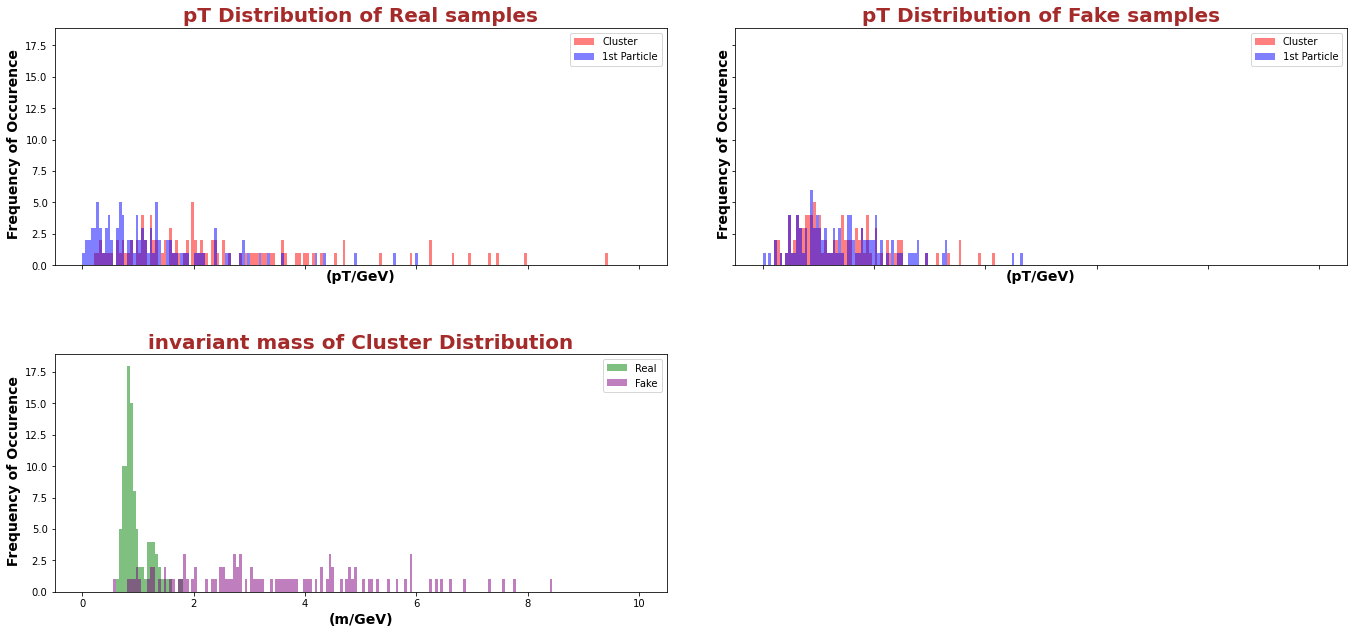

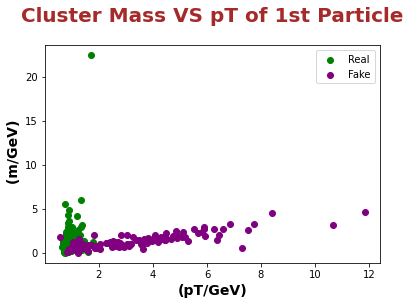

>102, c1=-0.083, c2=-0.029 g=0.030
>103, c1=-0.072, c2=-0.032 g=0.034
>104, c1=-0.068, c2=-0.030 g=0.032
>105, c1=-0.080, c2=-0.034 g=0.034
>106, c1=-0.088, c2=-0.036 g=0.036
>107, c1=-0.081, c2=-0.035 g=0.036
>108, c1=-0.080, c2=-0.033 g=0.036
>109, c1=-0.091, c2=-0.031 g=0.033
>110, c1=-0.080, c2=-0.035 g=0.039
>111, c1=-0.080, c2=-0.036 g=0.032
>112, c1=-0.087, c2=-0.033 g=0.035
>113, c1=-0.077, c2=-0.032 g=0.027
>114, c1=-0.087, c2=-0.036 g=0.032
>115, c1=-0.069, c2=-0.037 g=0.028
>116, c1=-0.077, c2=-0.033 g=0.037
>117, c1=-0.090, c2=-0.034 g=0.033
>118, c1=-0.079, c2=-0.035 g=0.036
>119, c1=-0.079, c2=-0.034 g=0.037
>120, c1=-0.072, c2=-0.034 g=0.041
>121, c1=-0.096, c2=-0.032 g=0.042
>122, c1=-0.081, c2=-0.035 g=0.030
>123, c1=-0.077, c2=-0.037 g=0.035
>124, c1=-0.089, c2=-0.033 g=0.040
>125, c1=-0.072, c2=-0.032 g=0.035
>126, c1=-0.088, c2=-0.035 g=0.037
>127, c1=-0.076, c2=-0.037 g=0.041
>128, c1=-0.087, c2=-0.035 g=0.040
>129, c1=-0.064, c2=-0.040 g=0.020
>130, c1=-0.079, c2=

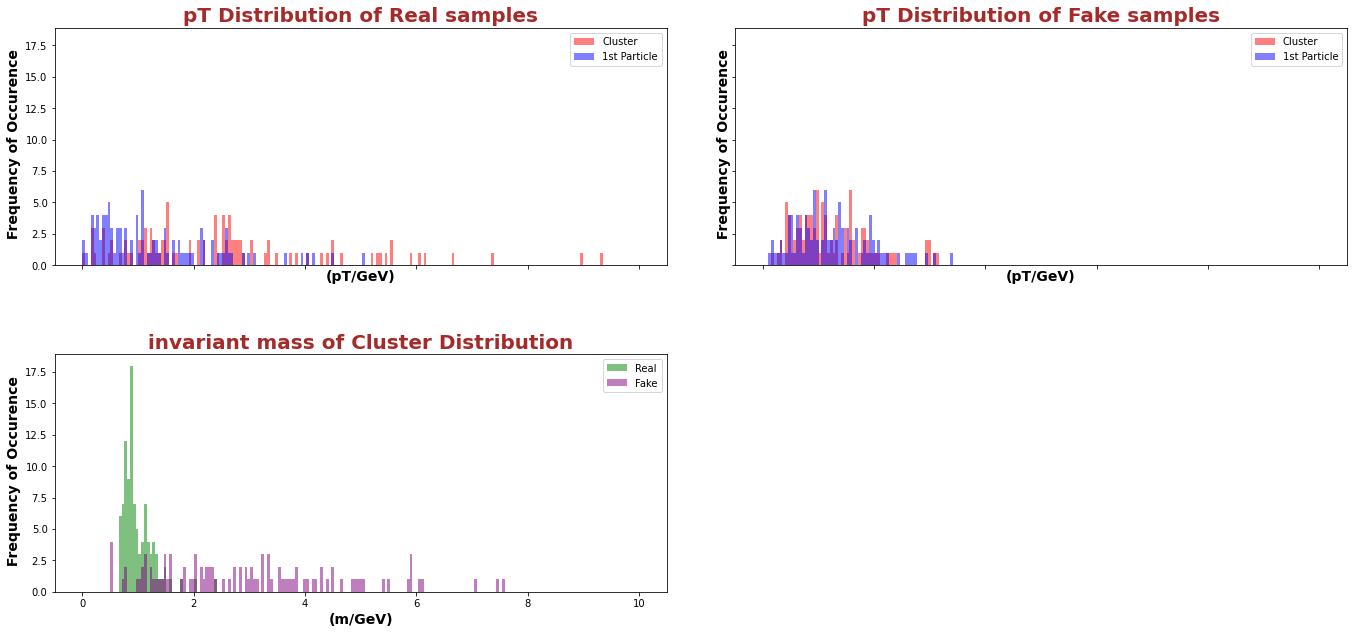

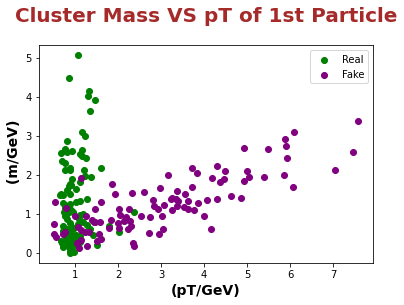

>203, c1=-0.080, c2=-0.029 g=0.027
>204, c1=-0.077, c2=-0.028 g=0.038
>205, c1=-0.100, c2=-0.032 g=0.035
>206, c1=-0.081, c2=-0.029 g=0.023
>207, c1=-0.089, c2=-0.030 g=0.039
>208, c1=-0.075, c2=-0.027 g=0.032
>209, c1=-0.078, c2=-0.030 g=0.040
>210, c1=-0.075, c2=-0.029 g=0.036
>211, c1=-0.069, c2=-0.034 g=0.036
>212, c1=-0.081, c2=-0.018 g=0.037
>213, c1=-0.068, c2=-0.035 g=0.031
>214, c1=-0.076, c2=-0.026 g=0.028
>215, c1=-0.081, c2=-0.027 g=0.030
>216, c1=-0.088, c2=-0.022 g=0.022
>217, c1=-0.073, c2=-0.028 g=0.034
>218, c1=-0.091, c2=-0.031 g=0.041
>219, c1=-0.086, c2=-0.021 g=0.038
>220, c1=-0.073, c2=-0.031 g=0.027
>221, c1=-0.075, c2=-0.026 g=0.022
>222, c1=-0.086, c2=-0.020 g=0.027
>223, c1=-0.078, c2=-0.025 g=0.031
>224, c1=-0.083, c2=-0.027 g=0.038
>225, c1=-0.084, c2=-0.019 g=0.029
>226, c1=-0.075, c2=-0.022 g=0.037
>227, c1=-0.072, c2=-0.022 g=0.024
>228, c1=-0.078, c2=-0.028 g=0.025
>229, c1=-0.091, c2=-0.020 g=0.038
>230, c1=-0.088, c2=-0.020 g=0.025
>231, c1=-0.090, c2=

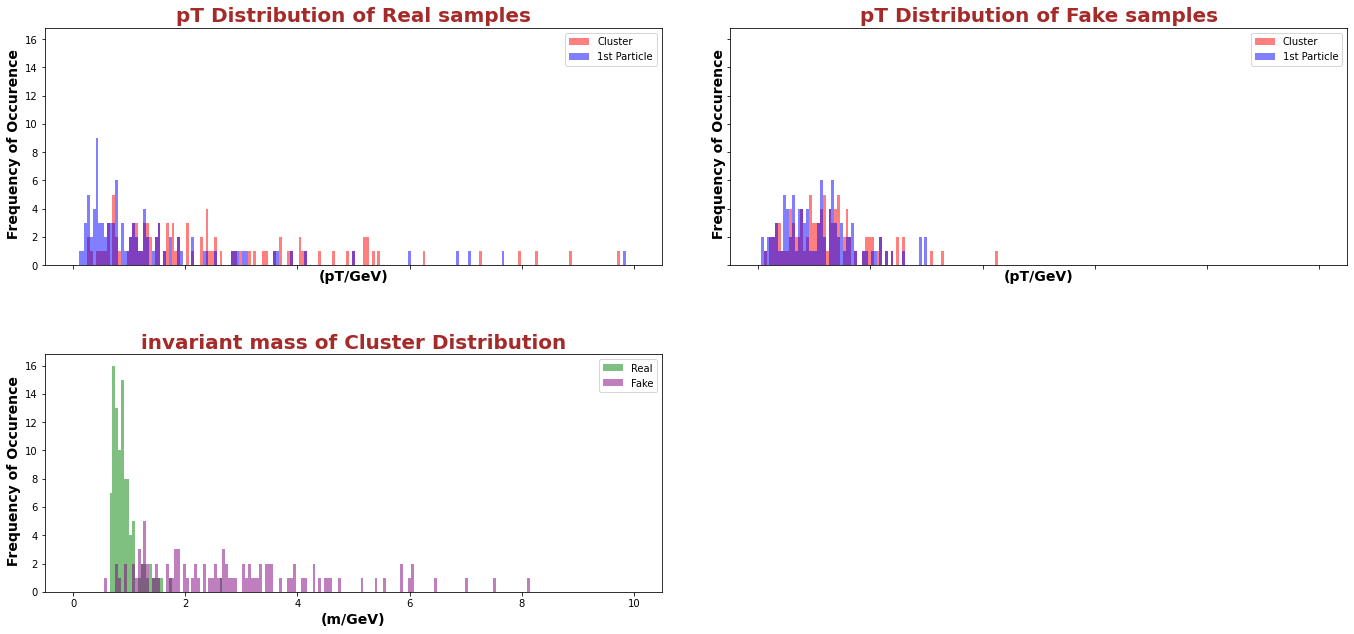

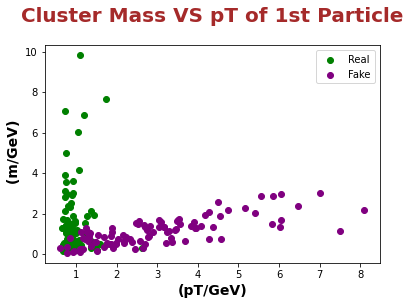

>304, c1=-0.088, c2=-0.020 g=0.024
>305, c1=-0.085, c2=-0.018 g=0.026
>306, c1=-0.075, c2=-0.017 g=0.021
>307, c1=-0.090, c2=-0.021 g=0.027
>308, c1=-0.091, c2=-0.023 g=0.027
>309, c1=-0.068, c2=-0.017 g=0.025
>310, c1=-0.102, c2=-0.019 g=0.025
>311, c1=-0.069, c2=-0.024 g=0.030
>312, c1=-0.074, c2=-0.023 g=0.022
>313, c1=-0.080, c2=-0.023 g=0.029
>314, c1=-0.061, c2=-0.023 g=0.026
>315, c1=-0.099, c2=-0.020 g=0.023
>316, c1=-0.069, c2=-0.019 g=0.025
>317, c1=-0.059, c2=-0.022 g=0.025
>318, c1=-0.090, c2=-0.017 g=0.024
>319, c1=-0.078, c2=-0.021 g=0.033
>320, c1=-0.090, c2=-0.025 g=0.027
>321, c1=-0.060, c2=-0.021 g=0.031
>322, c1=-0.091, c2=-0.023 g=0.025
>323, c1=-0.079, c2=-0.021 g=0.019
>324, c1=-0.084, c2=-0.022 g=0.028
>325, c1=-0.079, c2=-0.021 g=0.026
>326, c1=-0.073, c2=-0.022 g=0.033
>327, c1=-0.080, c2=-0.020 g=0.024
>328, c1=-0.073, c2=-0.028 g=0.027
>329, c1=-0.086, c2=-0.029 g=0.021
>330, c1=-0.068, c2=-0.027 g=0.019
>331, c1=-0.069, c2=-0.020 g=0.025
>332, c1=-0.067, c2=

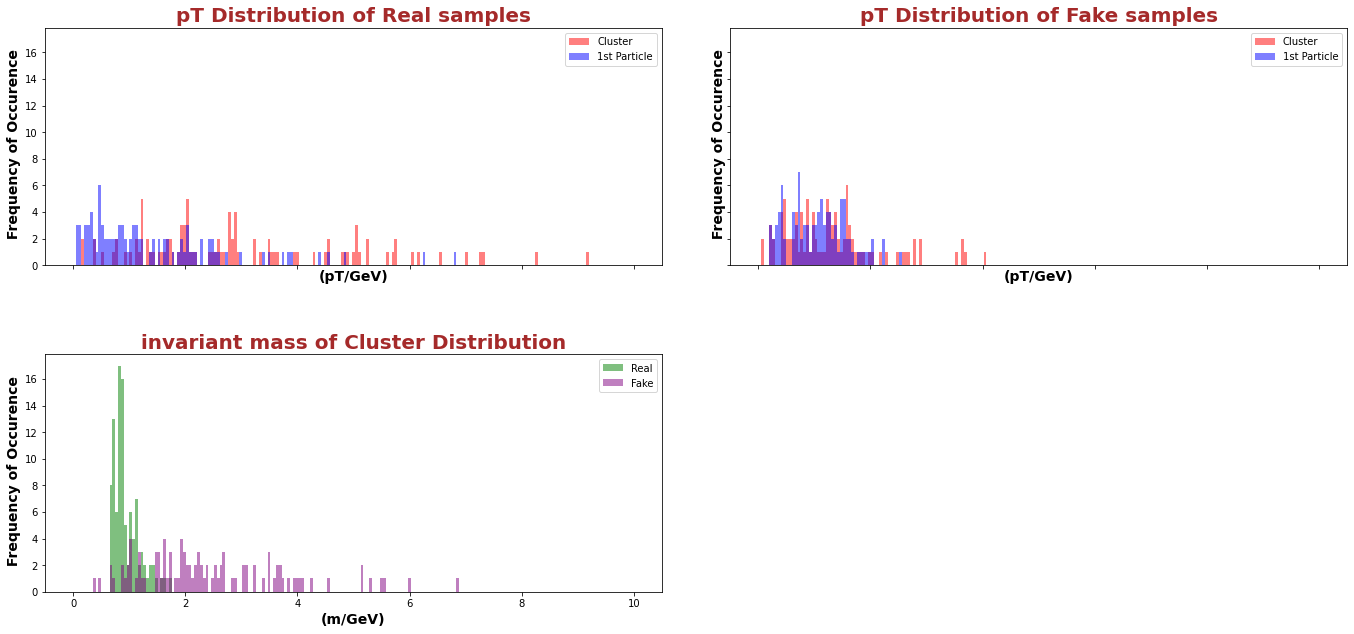

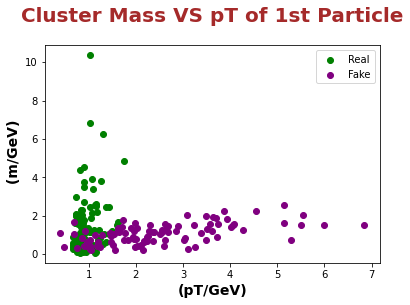

>405, c1=-0.079, c2=-0.034 g=0.038
>406, c1=-0.066, c2=-0.037 g=0.042
>407, c1=-0.045, c2=-0.036 g=0.042
>408, c1=-0.064, c2=-0.032 g=0.042
>409, c1=-0.058, c2=-0.038 g=0.044
>410, c1=-0.066, c2=-0.038 g=0.038
>411, c1=-0.065, c2=-0.030 g=0.036
>412, c1=-0.064, c2=-0.039 g=0.041
>413, c1=-0.071, c2=-0.042 g=0.038
>414, c1=-0.074, c2=-0.047 g=0.043
>415, c1=-0.066, c2=-0.043 g=0.035
>416, c1=-0.081, c2=-0.041 g=0.038
>417, c1=-0.052, c2=-0.039 g=0.042
>418, c1=-0.050, c2=-0.038 g=0.018
>419, c1=-0.062, c2=-0.036 g=0.034
>420, c1=-0.052, c2=-0.042 g=0.034
>421, c1=-0.067, c2=-0.042 g=0.033
>422, c1=-0.039, c2=-0.038 g=0.038
>423, c1=-0.044, c2=-0.037 g=0.038
>424, c1=-0.087, c2=-0.036 g=0.035
>425, c1=-0.046, c2=-0.044 g=0.045
>426, c1=-0.041, c2=-0.036 g=0.053
>427, c1=-0.045, c2=-0.039 g=0.045
>428, c1=-0.055, c2=-0.040 g=0.044
>429, c1=-0.047, c2=-0.039 g=0.044
>430, c1=-0.055, c2=-0.042 g=0.046
>431, c1=-0.054, c2=-0.044 g=0.039
>432, c1=-0.059, c2=-0.047 g=0.038
>433, c1=-0.072, c2=

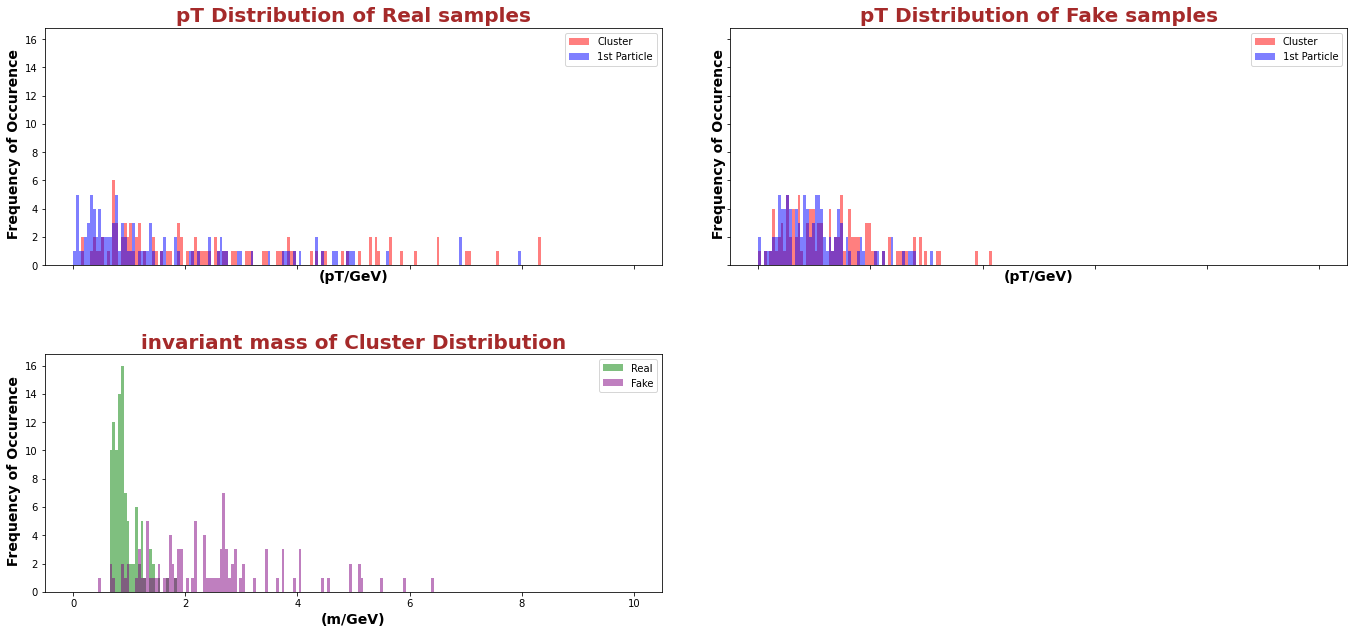

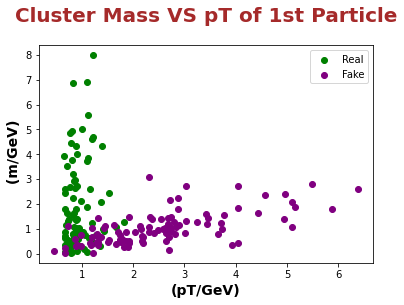

>506, c1=-0.024, c2=-0.078 g=0.082
>507, c1=-0.013, c2=-0.080 g=0.082
>508, c1=-0.039, c2=-0.083 g=0.081
>509, c1=-0.022, c2=-0.083 g=0.075
>510, c1=-0.011, c2=-0.085 g=0.083
>511, c1=-0.030, c2=-0.080 g=0.068
>512, c1=-0.013, c2=-0.086 g=0.084
>513, c1=-0.012, c2=-0.084 g=0.089
>514, c1=-0.006, c2=-0.077 g=0.078
>515, c1=-0.025, c2=-0.084 g=0.085
>516, c1=-0.014, c2=-0.083 g=0.076
>517, c1=-0.040, c2=-0.080 g=0.089
>518, c1=-0.010, c2=-0.086 g=0.098
>519, c1=-0.005, c2=-0.084 g=0.090
>520, c1=-0.023, c2=-0.083 g=0.090
>521, c1=-0.015, c2=-0.089 g=0.081
>522, c1=-0.031, c2=-0.087 g=0.088
>523, c1=-0.031, c2=-0.083 g=0.089
>524, c1=-0.050, c2=-0.089 g=0.093
>525, c1=-0.030, c2=-0.087 g=0.075
>526, c1=-0.006, c2=-0.086 g=0.086
>527, c1=-0.024, c2=-0.087 g=0.087
>528, c1=-0.012, c2=-0.087 g=0.088
>529, c1=-0.006, c2=-0.091 g=0.084
>530, c1=-0.011, c2=-0.090 g=0.081
>531, c1=0.009, c2=-0.085 g=0.080
>532, c1=-0.036, c2=-0.082 g=0.097
>533, c1=-0.003, c2=-0.092 g=0.087
>534, c1=-0.021, c2=-

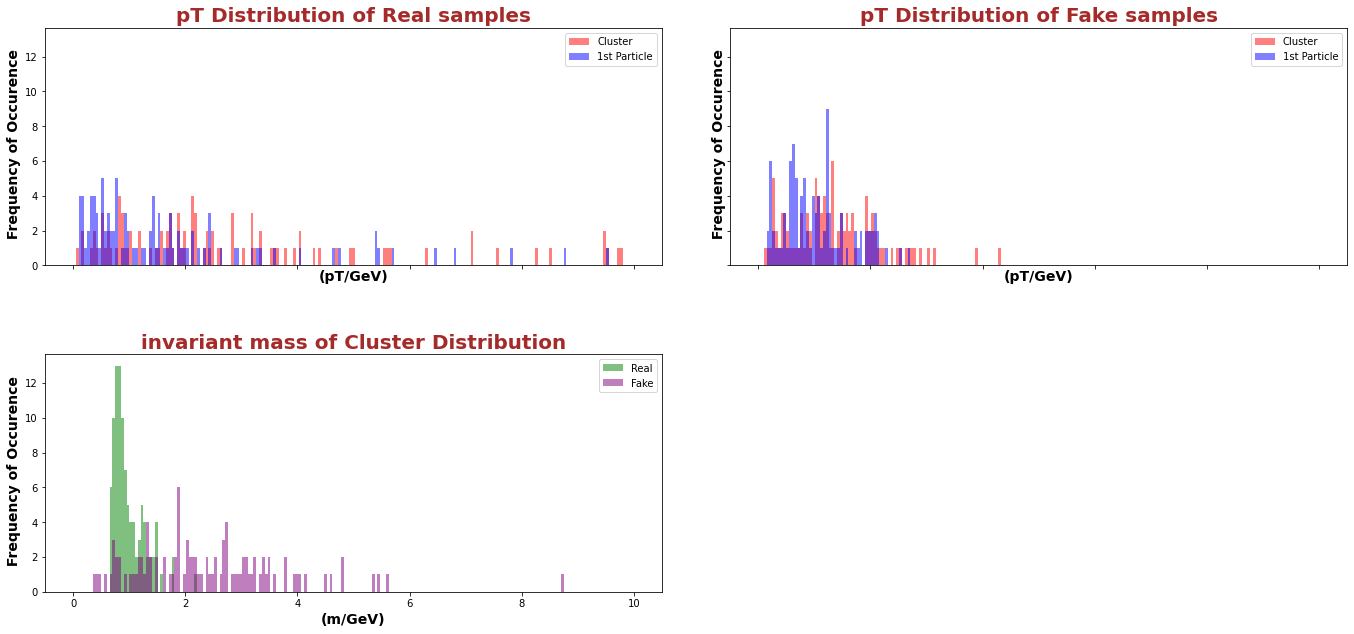

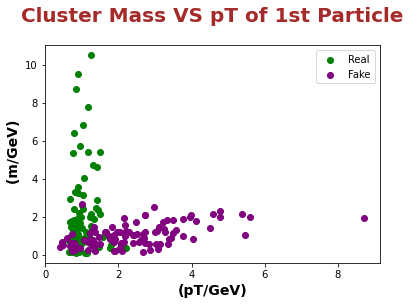

>607, c1=-0.042, c2=-0.090 g=0.094
>608, c1=-0.039, c2=-0.091 g=0.096
>609, c1=-0.036, c2=-0.088 g=0.093
>610, c1=-0.001, c2=-0.087 g=0.086
>611, c1=0.003, c2=-0.094 g=0.092
>612, c1=-0.013, c2=-0.092 g=0.086
>613, c1=-0.023, c2=-0.095 g=0.090
>614, c1=-0.020, c2=-0.085 g=0.095
>615, c1=-0.003, c2=-0.088 g=0.092
>616, c1=-0.022, c2=-0.087 g=0.087
>617, c1=-0.025, c2=-0.087 g=0.086
>618, c1=-0.008, c2=-0.093 g=0.107
>619, c1=-0.021, c2=-0.097 g=0.091
>620, c1=-0.019, c2=-0.091 g=0.090
>621, c1=-0.003, c2=-0.098 g=0.089
>622, c1=-0.042, c2=-0.087 g=0.097
>623, c1=-0.010, c2=-0.096 g=0.085
>624, c1=-0.006, c2=-0.094 g=0.092
>625, c1=-0.021, c2=-0.094 g=0.102
>626, c1=-0.011, c2=-0.091 g=0.086
>627, c1=-0.022, c2=-0.085 g=0.094
>628, c1=-0.000, c2=-0.088 g=0.087
>629, c1=-0.043, c2=-0.089 g=0.078
>630, c1=-0.010, c2=-0.091 g=0.094
>631, c1=-0.012, c2=-0.090 g=0.083
>632, c1=-0.060, c2=-0.085 g=0.102
>633, c1=-0.008, c2=-0.095 g=0.086
>634, c1=-0.017, c2=-0.083 g=0.092
>635, c1=-0.028, c2=-

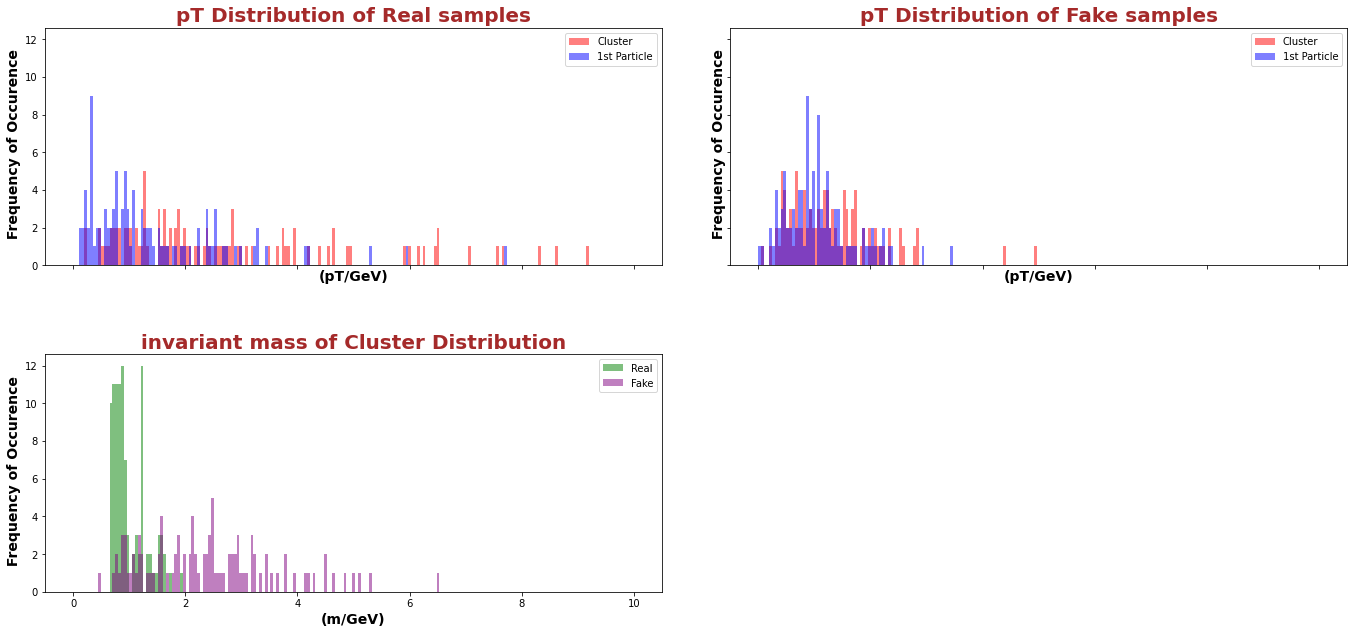

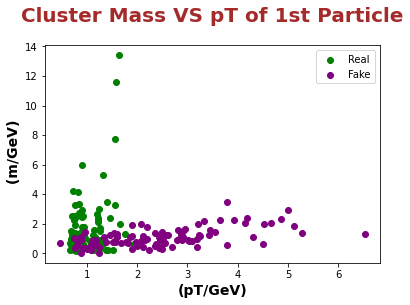

>708, c1=-0.057, c2=-0.085 g=0.087
>709, c1=-0.022, c2=-0.080 g=0.092
>710, c1=-0.013, c2=-0.075 g=0.084
>711, c1=-0.013, c2=-0.074 g=0.084
>712, c1=-0.035, c2=-0.071 g=0.080
>713, c1=-0.025, c2=-0.079 g=0.076
>714, c1=-0.013, c2=-0.073 g=0.094
>715, c1=-0.019, c2=-0.074 g=0.075
>716, c1=-0.015, c2=-0.078 g=0.073
>717, c1=-0.019, c2=-0.085 g=0.084
>718, c1=-0.006, c2=-0.079 g=0.074
>719, c1=-0.003, c2=-0.083 g=0.092
>720, c1=-0.051, c2=-0.083 g=0.083
>721, c1=-0.024, c2=-0.089 g=0.085
>722, c1=-0.020, c2=-0.076 g=0.088
>723, c1=0.008, c2=-0.070 g=0.070
>724, c1=-0.016, c2=-0.074 g=0.083
>725, c1=-0.048, c2=-0.078 g=0.083
>726, c1=-0.010, c2=-0.083 g=0.070
>727, c1=-0.010, c2=-0.077 g=0.079
>728, c1=-0.014, c2=-0.080 g=0.071
>729, c1=0.012, c2=-0.072 g=0.081
>730, c1=-0.012, c2=-0.065 g=0.093
>731, c1=-0.016, c2=-0.082 g=0.088
>732, c1=-0.013, c2=-0.071 g=0.070
>733, c1=-0.008, c2=-0.087 g=0.089
>734, c1=-0.021, c2=-0.083 g=0.077
>735, c1=0.014, c2=-0.075 g=0.088
>736, c1=-0.008, c2=-0.

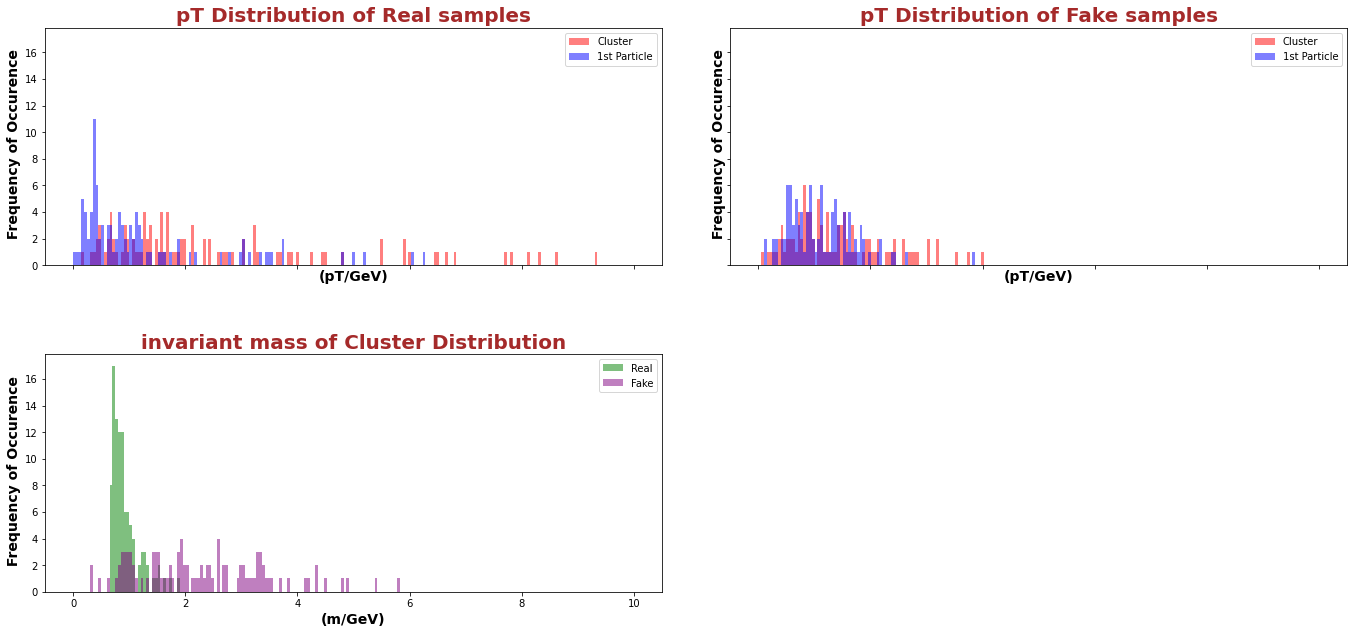

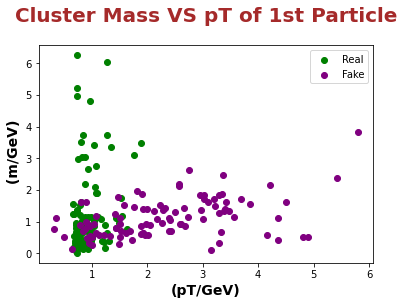

>809, c1=0.013, c2=-0.089 g=0.101
>810, c1=-0.013, c2=-0.091 g=0.099
>811, c1=-0.011, c2=-0.099 g=0.094
>812, c1=0.001, c2=-0.093 g=0.103
>813, c1=-0.009, c2=-0.092 g=0.115
>814, c1=-0.004, c2=-0.100 g=0.108
>815, c1=-0.021, c2=-0.096 g=0.108
>816, c1=0.032, c2=-0.094 g=0.107
>817, c1=-0.023, c2=-0.099 g=0.095
>818, c1=0.021, c2=-0.095 g=0.105
>819, c1=-0.013, c2=-0.094 g=0.090
>820, c1=-0.005, c2=-0.099 g=0.090
>821, c1=-0.010, c2=-0.090 g=0.086
>822, c1=0.007, c2=-0.096 g=0.097
>823, c1=-0.029, c2=-0.087 g=0.072
>824, c1=0.020, c2=-0.098 g=0.097
>825, c1=0.035, c2=-0.093 g=0.099
>826, c1=0.002, c2=-0.098 g=0.096
>827, c1=0.030, c2=-0.092 g=0.089
>828, c1=0.001, c2=-0.085 g=0.102
>829, c1=-0.005, c2=-0.096 g=0.088
>830, c1=0.010, c2=-0.097 g=0.098
>831, c1=-0.011, c2=-0.103 g=0.108
>832, c1=0.011, c2=-0.099 g=0.090
>833, c1=-0.001, c2=-0.100 g=0.095
>834, c1=-0.007, c2=-0.095 g=0.111
>835, c1=-0.011, c2=-0.099 g=0.102
>836, c1=0.014, c2=-0.104 g=0.094
>837, c1=0.027, c2=-0.107 g=0.096

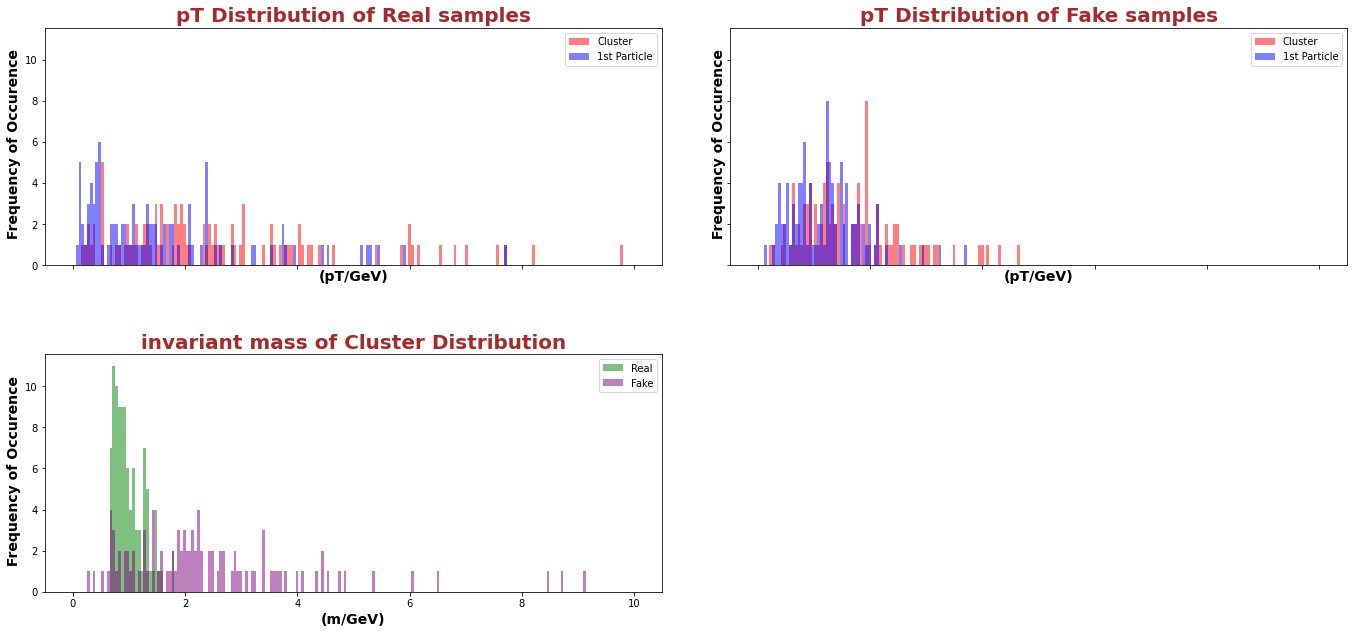

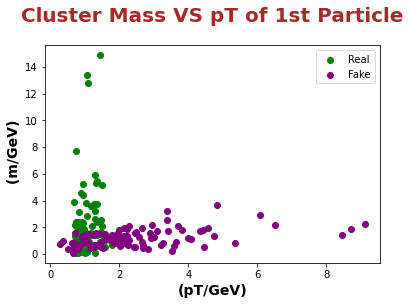

>910, c1=0.001, c2=-0.102 g=0.114
>911, c1=0.005, c2=-0.110 g=0.115
>912, c1=-0.002, c2=-0.100 g=0.106
>913, c1=-0.012, c2=-0.109 g=0.109
>914, c1=0.019, c2=-0.107 g=0.105
>915, c1=0.018, c2=-0.112 g=0.081
>916, c1=-0.000, c2=-0.103 g=0.088
>917, c1=0.017, c2=-0.108 g=0.100
>918, c1=-0.016, c2=-0.091 g=0.102
>919, c1=0.014, c2=-0.099 g=0.101
>920, c1=0.004, c2=-0.113 g=0.109
>921, c1=-0.001, c2=-0.104 g=0.108
>922, c1=0.020, c2=-0.106 g=0.116
>923, c1=0.017, c2=-0.102 g=0.116
>924, c1=0.011, c2=-0.110 g=0.105
>925, c1=0.015, c2=-0.099 g=0.104
>926, c1=-0.005, c2=-0.093 g=0.108
>927, c1=0.023, c2=-0.104 g=0.111
>928, c1=0.019, c2=-0.103 g=0.106
>929, c1=0.013, c2=-0.096 g=0.115
>930, c1=0.010, c2=-0.098 g=0.104
>931, c1=0.006, c2=-0.102 g=0.102
>932, c1=0.000, c2=-0.099 g=0.107
>933, c1=0.007, c2=-0.104 g=0.113
>934, c1=-0.008, c2=-0.098 g=0.102
>935, c1=-0.019, c2=-0.098 g=0.109
>936, c1=0.010, c2=-0.088 g=0.111
>937, c1=-0.002, c2=-0.094 g=0.099
>938, c1=0.014, c2=-0.102 g=0.096
>939,

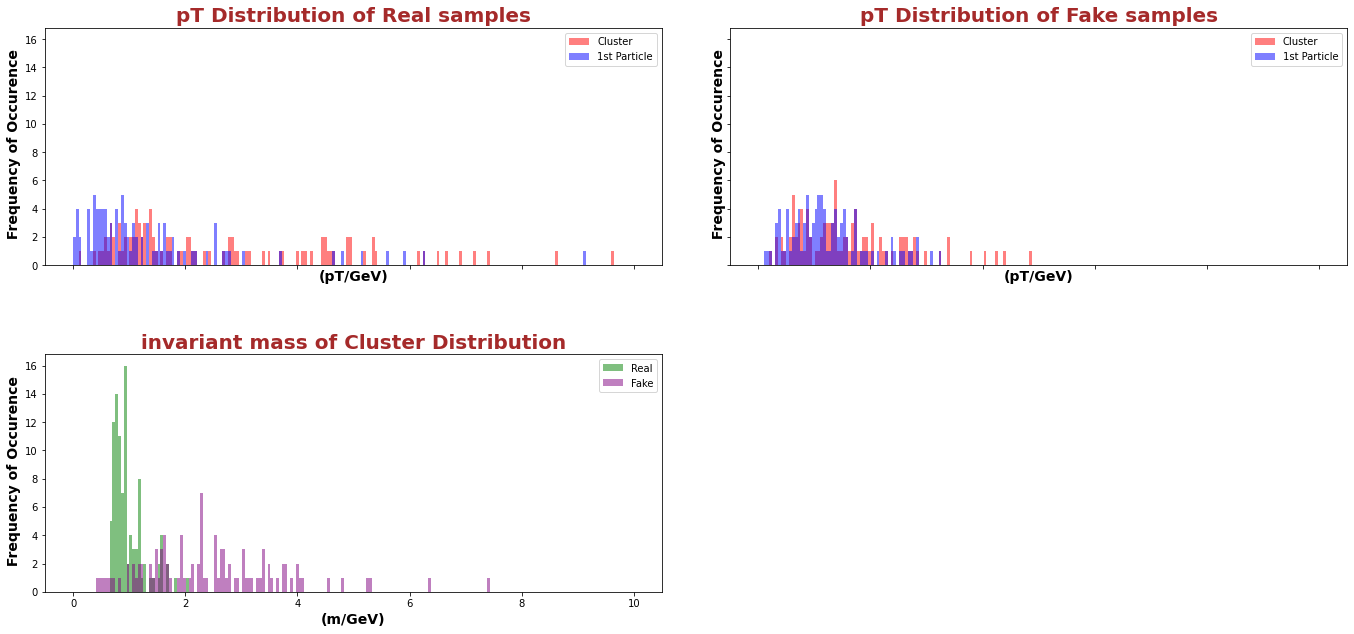

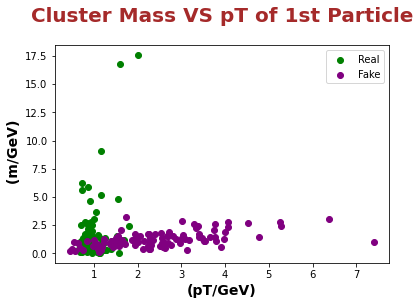

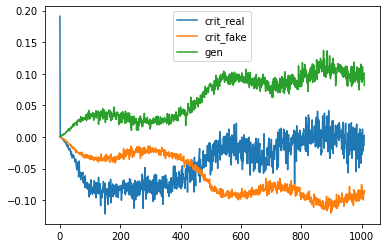

In [157]:
# size of the latent space
latent_dim = 15
# create the discriminator
critic = define_critic()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, critic)
# train model
train(generator, critic, gan_model, latent_dim)

In [158]:
# This Cell Block Generates Large number of Fake Samples
# And calculates the Minimum value of Invariant mass of Cluster that is observed in fake samples in GeV
# It should be greater than .279 approx, having less than this value isnt physically possible

x,y = generate_fake_samples(generator,latent_dim,6000)
i=0
h = zeros((x.shape[0],1))
while i < x.shape[0]:
  h[i][0] = calcmsqr(x[i][0],x[i][1],x[i][2],x[i][3],x[i][4],x[i][5],.13957,.13957)
  h[i][0] = np.sqrt(h[i][0])
  i=i+1
t1=h[0][0]
i=0
while i < h.shape[0]:
  if (h[i][0]<t1):
    t1=h[i][0]
  i=i+1
print(t1)

0.29192694384097184


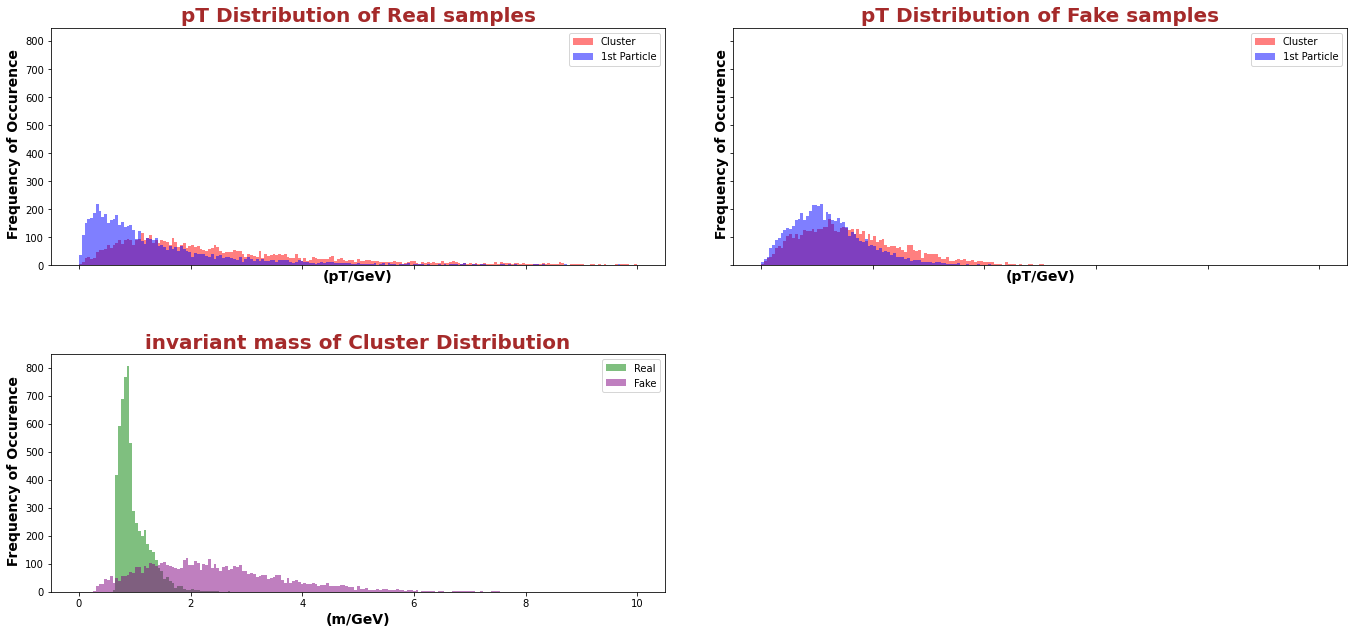

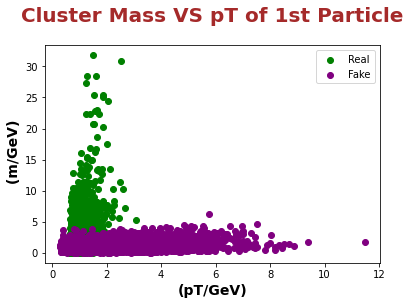

In [159]:
# Summarize perfomance for almost all samples included, plot graphs
summarize_performance(1,generator, latent_dim, n=6000)

In [ ]:
#display2 fucntion plots the scatter plot of Mass of cluster VS pT of 1st Particle

In [112]:
def display2(X,Y):
  v=zeros((X.shape[0],2))
  i=0
  while i < X.shape[0]:
    v[i][0]= (X[i][0]*X[i][0])+(X[i][1]*X[i][1]) # px*px + py*py for Cluster
    v[i][1]= (X[i][3]*X[i][3])+(X[i][4]*X[i][4]) # px*px + py*py for Particle
    v[i][0]= np.sqrt(v[i][0])
    v[i][1]= np.sqrt(v[i][1])
    i=i+1
  #plt.subplot(1, 2, 1)
  #plt.hist(v[:,0],color='red',alpha=0.5,bins=np.linspace(0,1000000000*0.2*0.25*0.2,50)) # Red For Cluster
  #plt.hist(v[:,1],color='blue',alpha=0.5,bins=np.linspace(0,1000000000*0.2*0.25*0.2,50))  # Blue for Particle
  #plt.title('Squared pT Distribution of Real samples')
 

  w=zeros((Y.shape[0],2))
  i=0
  while i < Y.shape[0]:
    w[i][0]= (Y[i][0]*Y[i][0])+(Y[i][1]*Y[i][1]) # px*px + py*py for Cluster
    w[i][1]= (Y[i][3]*Y[i][3])+(Y[i][4]*Y[i][4]) # px*px + py*py for Particle
    w[i][0]= np.sqrt(w[i][0])
    w[i][1]= np.sqrt(w[i][1])
    i=i+1
  #plt.subplot(1, 2, 2)
  #plt.hist(w[:,0],color='red',alpha=0.5,bins=np.linspace(0,1000000000*0.2*0.25*0.2,50)) # Red For Cluster
  #plt.hist(w[:,1],color='blue',alpha=0.5,bins=np.linspace(0,1000000000*0.2*0.25*0.2,50))  # Blue for Particle
  #plt.title('Squared pT Distribution of Fake samples')

  g=zeros((X.shape[0],1))          # For Real Samples
  i=0
  while i < X.shape[0]:
    g[i][0]= calcmsqr(X[i][0],X[i][1],X[i][2],X[i][3],X[i][4],X[i][5],.13957,.13957)  # Calc Sq. Mass of cluster
    g[i][0]= np.sqrt(g[i][0])
    i=i+1
  
  h=zeros((Y.shape[0],1))         # For Fake Samples
  i=0
  while i < Y.shape[0]:
    h[i][0]= calcmsqr(Y[i][0],Y[i][1],Y[i][2],Y[i][3],Y[i][4],Y[i][5],.13957,.13957)  # Calc Sq. Mass of cluster
    h[i][0]= np.sqrt(h[i][0])
    i=i+1
  
 

  
  
  
  plt.scatter(g[:,0],v[:,1],color='green',label='Real') #
  plt.scatter(h[:,0],w[:,1],color='purple',label='Fake')  # 
  plt.title('Cluster Mass VS pT of 1st Particle',fontweight="bold",color='brown',fontsize=20,y=1.08)
  plt.xlabel("(pT/GeV)",fontweight="bold",color='black',fontsize=14)
  plt.ylabel(" (m/GeV)",fontweight="bold",color='black',fontsize=14)
  plt.legend() 
  
  #ax[1,1].axis('off')
  
  #fig.subplots_adjust(hspace=1000)
  #plt.tight_layout(pad =5)
  #plt.savefig('test_6.pdf')         #    These two lines to 
  #files.download('test_6.pdf')      #    Download data
  plt.show()

In [ ]:
# Following are just temporary codes still working on

In [ ]:
# I was writing FOllowing Function to Caluclate chi2 of 2 histogram frequencies but I ran into some trouble
# as formula includes divinding by expected frequencies, and some of our data bins does have zero frequencies, so I was stuck at this

In [ ]:
def calcchi(X,Y):
  v=zeros((X.shape[0],2))
  i=0
  while i < X.shape[0]:
    v[i][0]= (X[i][0]*X[i][0])+(X[i][1]*X[i][1]) # px*px + py*py for Cluster
    v[i][1]= (X[i][3]*X[i][3])+(X[i][4]*X[i][4]) # px*px + py*py for Particle
    i=i+1
  #plt.subplot(1, 2, 1)
  #plt.hist(v[:,0],color='red',alpha=0.5,bins=np.linspace(0,1000000000*0.2*0.25*0.2,50)) # Red For Cluster
  #plt.hist(v[:,1],color='blue',alpha=0.5,bins=np.linspace(0,1000000000*0.2*0.25*0.2,50))  # Blue for Particle
  #plt.title('Squared pT Distribution of Real samples')
 

  w=zeros((Y.shape[0],2))
  i=0
  while i < Y.shape[0]:
    w[i][0]= (Y[i][0]*Y[i][0])+(Y[i][1]*Y[i][1]) # px*px + py*py for Cluster
    w[i][1]= (Y[i][3]*Y[i][3])+(Y[i][4]*Y[i][4]) # px*px + py*py for Particle
    i=i+1
  #plt.subplot(1, 2, 2)
  #plt.hist(w[:,0],color='red',alpha=0.5,bins=np.linspace(0,1000000000*0.2*0.25*0.2,50)) # Red For Cluster
  #plt.hist(w[:,1],color='blue',alpha=0.5,bins=np.linspace(0,1000000000*0.2*0.25*0.2,50))  # Blue for Particle
  #plt.title('Squared pT Distribution of Fake samples')

  g=zeros((X.shape[0],1))          # For Real Samples
  i=0
  while i < X.shape[0]:
    g[i][0]= calcmsqr(X[i][0],X[i][1],X[i][2],X[i][3],X[i][4],X[i][5],139.57,139.57)  # Calc Sq. Mass of cluster
    #g[i][0]= np.sqrt(g[i][0])
    i=i+1
  
  h=zeros((Y.shape[0],1))         # For Fake Samples
  i=0
  while i < Y.shape[0]:
    h[i][0]= calcmsqr(Y[i][0],Y[i][1],Y[i][2],Y[i][3],Y[i][4],Y[i][5],139.57,139.57)  # Calc Sq. Mass of cluster
    #h[i][0]= np.sqrt(h[i][0])
    i=i+1
  
 

  
  fig, ax = plt.subplots(nrows=2,ncols= 2,figsize=(20, 10),sharex=True, sharey=True) 
  a=ax[0,0].hist(v[:,0],color='red',alpha=0.5,bins=np.linspace(0,1000000000*0.2*0.25*0.2,200),label='Cluster') # Red For Cluster
  b=ax[0,0].hist(v[:,1],color='blue',alpha=0.5,bins=np.linspace(0,1000000000*0.2*0.25*0.2,200),label='1st Particle')  # Blue for Particle
  ax[0,0].set_title('Squared pT Distribution of Real samples',fontweight="bold",color='brown',fontsize=20)
  ax[0,0].set_xlabel("(pT/MeV)^2",fontweight="bold",color='black',fontsize=10)
  ax[0,0].set_ylabel(" Frequency of Occurence",fontweight="bold",color='black',fontsize=10)
  ax[0,0].legend()

  c=ax[0,1].hist(w[:,0],color='red',alpha=0.5,bins=np.linspace(0,1000000000*0.2*0.25*0.2,200),label='Cluster') # Red For Cluster
  d=ax[0,1].hist(w[:,1],color='blue',alpha=0.5,bins=np.linspace(0,1000000000*0.2*0.25*0.2,200),label='1st Particle')  # Blue for Particle
  ax[0,1].set_title('Squared pT Distribution of Fake samples',fontweight="bold",color='brown',fontsize=20)
  ax[0,1].set_xlabel("(pT/MeV)^2",fontweight="bold",color='black',fontsize=10)
  ax[0,1].set_ylabel(" Frequency of Occurence",fontweight="bold",color='black',fontsize=10)
  ax[0,1].legend()

  e=ax[1,0].hist(g[:,0],color='green',bins=np.linspace(0,1000000000*0.2*0.25*0.2,200),alpha=0.5,label='Real') #
  f=ax[1,0].hist(h[:,0],color='purple',bins=np.linspace(0,1000000000*0.2*0.25*0.2,200),alpha=0.5,label='Fake')  # 
  ax[1,0].set_title('invariant mass of Cluster Distribution',fontweight="bold",color='brown',fontsize=20)
  ax[1,0].set_xlabel("(m/MeV)^2",fontweight="bold",color='black',fontsize=10)
  ax[1,0].set_ylabel(" Frequency of Occurence",fontweight="bold",color='black',fontsize=10)
  ax[1,0].legend() 
  
 
  ax[1,1].axis('off')

  chi2 , p = chisquare(f[0]>0,e[0]>0)
  print(" chi2 result for Sq. Mass of Cluster Histogram : ",chi2,"  p value:  ",p)
  chi2 , p = chisquare(c[0]>0,a[0]>0)
  print(" chi2 result for Sq. pT of Cluster Histogram : ",chi2,"  p value:  ",p)
  chi2 , p = chisquare(d[0]>0,b[0]>0)
  print(" chi2 result for Sq. pT of 1st Particle Histogram : ",chi2,"  p value:  ",p)
 
  print(a[0])
  print(b[0])
  print(e[0])

  #fig.subplots_adjust(hspace=1000)
  fig.tight_layout(pad =5)
  #plt.savefig('test_3.pdf')         #    These two lines to 
  #files.download('test_3.pdf')      #    Download data
  plt.show()

In [ ]:
x,y =generate_fake_samples(generator,latent_dim,1000)
x

array([[ 1388.1224  ,  2552.996   ,  1811.8916  ,   351.27457 ,
         1518.9935  ,   693.7977  ],
       [-2716.2585  , -2568.6196  ,   993.0069  ,  -225.93944 ,
         -502.6875  ,   797.7005  ],
       [ 1395.9275  , -2165.753   , -2009.2065  ,   452.70667 ,
        -1968.316   , -1041.244   ],
       ...,
       [  -46.89472 , -1531.8854  , -1443.6812  ,   -19.85093 ,
         -151.8261  ,    61.821312],
       [ 1266.7194  ,  2286.062   ,  2480.6226  ,   160.42041 ,
          492.35257 ,   445.65872 ],
       [ -450.1111  ,  2089.386   , -1195.1248  ,  -310.72977 ,
          579.9929  ,  -310.37958 ]], dtype=float32)

In [ ]:
x,y =generate_real_samples(5)
x

array([[ 4572.93  ,  3686.39  ,  4805.3   ,   880.075 ,   664.043 ,
         1335.33  ],
       [ -147.916 ,   856.604 , -5119.06  ,  -437.668 ,   -41.2884,
        -1552.77  ],
       [ 4521.4   ,  -407.194 , -3624.56  ,  2818.98  ,  -334.81  ,
        -2858.45  ],
       [ 1633.    ,  1489.17  ,  2567.15  ,   611.858 ,   323.209 ,
         1447.88  ],
       [  701.114 ,    20.1217,  1035.85  ,   819.812 ,   -96.1213,
          489.503 ]])